In [1]:
from warnings import filterwarnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler, LabelEncoder


filterwarnings("ignore")

In [2]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [3]:
train_df.shape

(891, 12)

In [4]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [8]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):

    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64"] and dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object"] and dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Gözlem Sayısı: {dataframe.shape[0]}")
    print(f"Değişken Sayısı: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

In [10]:
cat_cols, num_cols, cat_but_car = grab_col_names(train_df)

Gözlem Sayısı: 891
Değişken Sayısı: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [11]:
cat_cols

['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']

In [12]:
cat_cols = [col for col in cat_cols if "Survived" not in col]

In [13]:
cat_cols

['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch']

In [14]:
num_cols

['PassengerId', 'Age', 'Fare']

In [15]:
num_cols = [col for col in num_cols if "PassengerId" not in col]

In [16]:
num_cols

['Age', 'Fare']

In [17]:
cat_but_car

['Name', 'Ticket', 'Cabin']

In [18]:
# analysis of numerical variables

def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe[numerical_col].describe(quantiles).T)
    print("################################################")

    if plot:
        dataframe[numerical_col].hist()
        plt.title(f"{numerical_col} İsimli Sayısal Değişkenin Histogramı")
        plt.show(block = True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}))

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
5%         4.000000
10%       14.000000
20%       19.000000
30%       22.000000
40%       25.000000
50%       28.000000
60%       31.800000
70%       36.000000
80%       41.000000
90%       50.000000
95%       56.000000
99%       65.870000
100%      80.000000
max       80.000000
Name: Age, dtype: float64
################################################


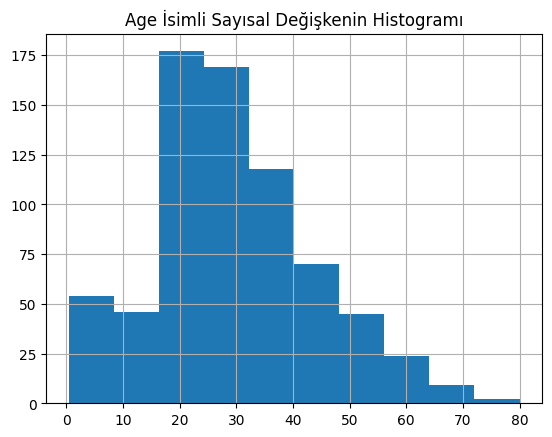

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
5%         7.225000
10%        7.550000
20%        7.854200
30%        8.050000
40%       10.500000
50%       14.454200
60%       21.679200
70%       27.000000
80%       39.687500
90%       77.958300
95%      112.079150
99%      249.006220
100%     512.329200
max      512.329200
Name: Fare, dtype: float64
################################################


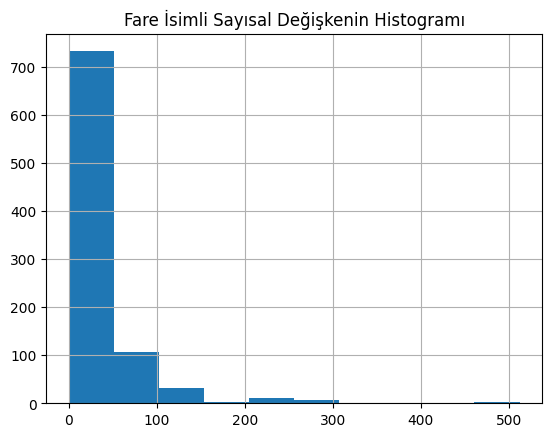

In [19]:
for col in num_cols:
    num_summary(train_df, col, plot = True)

In [20]:
# analysis of categorical variables

def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("################################################")

    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.title(f"{col_name} İsimli Kategorik Değişkeninin Sütun Grafiği")
        plt.show(block = True)

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}))

        Sex      Ratio
Sex                   
male    577  64.758698
female  314  35.241302
################################################


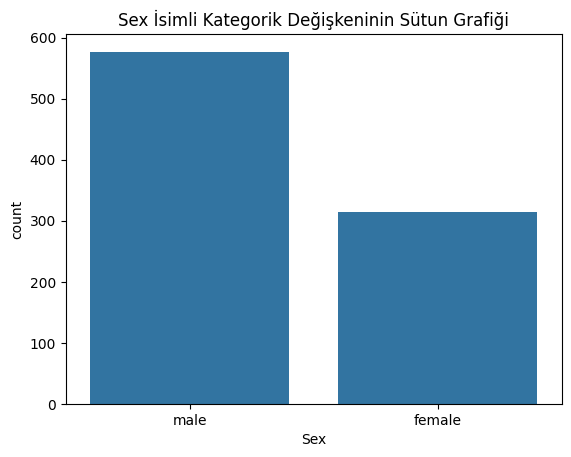

          Embarked      Ratio
Embarked                     
S              644  72.278339
C              168  18.855219
Q               77   8.641975
################################################


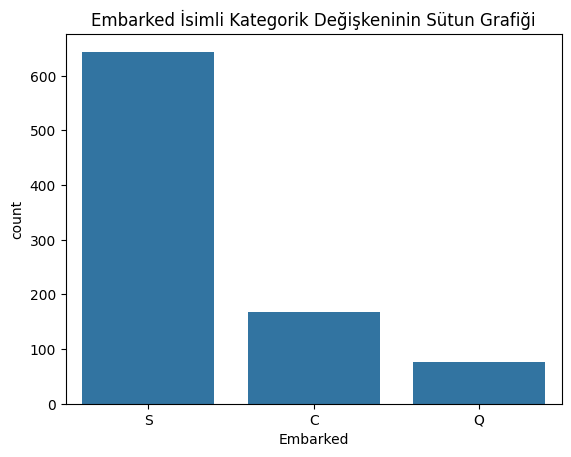

        Pclass      Ratio
Pclass                   
3          491  55.106622
1          216  24.242424
2          184  20.650954
################################################


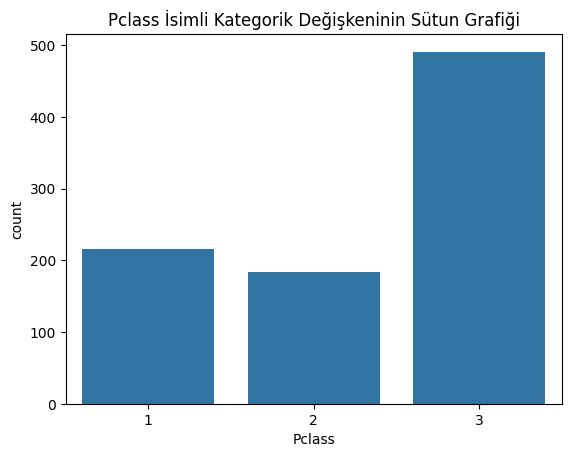

       SibSp      Ratio
SibSp                  
0        608  68.237935
1        209  23.456790
2         28   3.142536
4         18   2.020202
3         16   1.795735
8          7   0.785634
5          5   0.561167
################################################


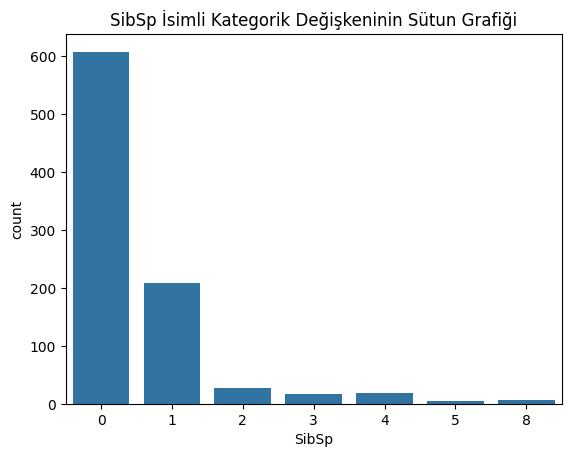

       Parch      Ratio
Parch                  
0        678  76.094276
1        118  13.243547
2         80   8.978676
5          5   0.561167
3          5   0.561167
4          4   0.448934
6          1   0.112233
################################################


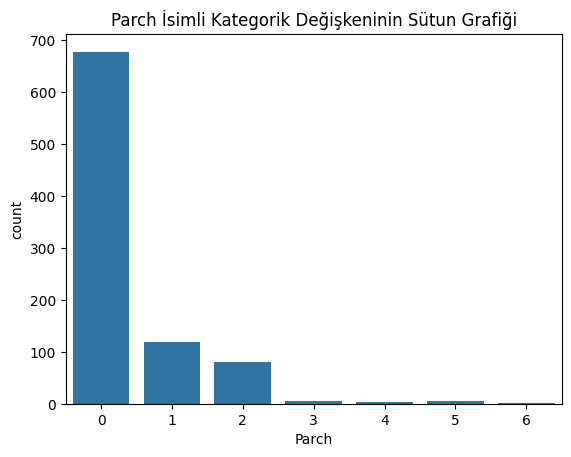

In [21]:
for col in cat_cols:
    cat_summary(train_df, col, plot = True)

In [22]:
for col in num_cols:
    target_summary_with_num(train_df, "Survived", col)

                Age
Survived           
0         30.626179
1         28.343690
               Fare
Survived           
0         22.117887
1         48.395408


In [23]:
for col in cat_cols:
    target_summary_with_cat(train_df, "Survived", col)

        TARGET_MEAN
Sex                
female     0.742038
male       0.188908
          TARGET_MEAN
Embarked             
C            0.553571
Q            0.389610
S            0.336957
        TARGET_MEAN
Pclass             
1          0.629630
2          0.472826
3          0.242363
       TARGET_MEAN
SibSp             
0         0.345395
1         0.535885
2         0.464286
3         0.250000
4         0.166667
5         0.000000
8         0.000000
       TARGET_MEAN
Parch             
0         0.343658
1         0.550847
2         0.500000
3         0.600000
4         0.000000
5         0.200000
6         0.000000


In [24]:
# outlier analysis

def outlier_thresholds(dataframe, col_name, q1 = 0.05, q3 = 0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interquantile_range
    up_limit = quartile3 + 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis = None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index = False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))].head())
    else:
        print(dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))])


    if index:
        outlier_index = dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def replace_with_thresholds(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [25]:
for col in num_cols:
    print(col, check_outlier(train_df, col))

Age False
Fare True


In [26]:
outlier_cols = [col for col in num_cols if check_outlier(train_df, col)]
outlier_cols

['Fare']

In [27]:
for col in outlier_cols:
    replace_with_thresholds(train_df,col)

In [28]:
for col in num_cols:
    print(col, check_outlier(train_df, col))


Age False
Fare False


In [29]:
# Missing observation analysis

train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [30]:
train_df["Age"].fillna(train_df["Age"].mean(), inplace = True)

In [31]:
train_df["Embarked"].fillna(train_df["Embarked"].mode()[0], inplace = True)

In [32]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [33]:
def high_correlated_cols(dataframe, corr_th=0.90, plot=False):
    """
    Identifies columns with high correlation (above a threshold) in a DataFrame.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame.
        corr_th (float, optional): The correlation threshold (default: 0.90).
        plot (bool, optional): Whether to create a heatmap of the correlation matrix (default: False).

    Returns:
        list: A list of column names with high correlation.
    """

    if not isinstance(dataframe, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    # Handle non-numerical columns (if necessary)
    numerical_cols = dataframe.select_dtypes(include=[np.number])
    if len(numerical_cols.columns) != len(dataframe.columns):
        print("Warning: Non-numerical columns found. Only using numerical columns for correlation.")

    corr = numerical_cols.corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()

    return drop_list


In [34]:
# high_correlated_cols(train_df, plot = True)

In [35]:
cat_cols

['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch']

In [36]:
num_cols

['Age', 'Fare']

In [37]:
cat_but_car

['Name', 'Ticket', 'Cabin']

In [38]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C


In [39]:
train_df["Sex"] = train_df["Sex"].replace({"female": 0, "male": 1})
test_df["Sex"] = test_df["Sex"].replace({"female": 0, "male": 1})

In [40]:
train_df["Family_size"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["Family_size"] = test_df["SibSp"] + test_df["Parch"] + 1

In [41]:
train_df["Is_alone"] = train_df["Family_size"].apply(lambda x:1 if x == 1 else 0)
test_df["Is_alone"] = test_df["Family_size"].apply(lambda x:1 if x == 1 else 0)

In [42]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Is_alone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S,2,0
4,5,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.000000,0,0,211536,13.0000,NaN,S,1,1
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.000000,0,0,112053,30.0000,B42,S,1,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29.699118,1,2,W./C. 6607,23.4500,NaN,S,4,0
889,890,1,1,"Behr, Mr. Karl Howell",1,26.000000,0,0,111369,30.0000,C148,C,1,1


In [43]:
train_df['Fare_per_person'] = train_df['Fare'] / train_df['Family_size']
test_df['Fare_per_person'] = test_df['Fare'] / test_df['Family_size']

In [44]:
train_df.isnull().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             0
Family_size          0
Is_alone             0
Fare_per_person      0
dtype: int64

In [45]:
le = LabelEncoder()
le_cols = ["Sex", "Embarked"]

for col in le_cols:
    train_df[col] = le.fit_transform(train_df[col])

In [46]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Is_alone,Fare_per_person
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,2,2,0,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,0,2,0,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,2,1,1,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,2,2,0,26.55000
4,5,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,2,1,1,8.05000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.000000,0,0,211536,13.0000,NaN,2,1,1,13.00000
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.000000,0,0,112053,30.0000,B42,2,1,1,30.00000
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29.699118,1,2,W./C. 6607,23.4500,NaN,2,4,0,5.86250
889,890,1,1,"Behr, Mr. Karl Howell",1,26.000000,0,0,111369,30.0000,C148,0,1,1,30.00000


In [47]:
train_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)

In [48]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_size,Is_alone,Fare_per_person
0,0,3,1,22.000000,1,0,7.2500,2,2,0,3.62500
1,1,1,0,38.000000,1,0,71.2833,0,2,0,35.64165
2,1,3,0,26.000000,0,0,7.9250,2,1,1,7.92500
3,1,1,0,35.000000,1,0,53.1000,2,2,0,26.55000
4,0,3,1,35.000000,0,0,8.0500,2,1,1,8.05000
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,2,1,1,13.00000
887,1,1,0,19.000000,0,0,30.0000,2,1,1,30.00000
888,0,3,0,29.699118,1,2,23.4500,2,4,0,5.86250
889,1,1,1,26.000000,0,0,30.0000,0,1,1,30.00000


In [49]:
train_df["Embarked"].value_counts()

Embarked
2    646
0    168
1     77
Name: count, dtype: int64

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

In [51]:
X = train_df.drop("Survived", axis = 1)
y = train_df["Survived"]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y,random_state = 42)

In [53]:
lg_model = LogisticRegression(random_state=42).fit(X_train, y_train)

In [54]:
y_pred = lg_model.predict(X_test)

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       165
           1       0.77      0.73      0.75       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



In [56]:
svc_model = SVC(random_state=42).fit(X_train, y_train)

In [57]:
y_pred = svc_model.predict(X_test)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.88      0.76       165
           1       0.63      0.31      0.42       103

    accuracy                           0.66       268
   macro avg       0.65      0.60      0.59       268
weighted avg       0.66      0.66      0.63       268



In [59]:
dt_model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [60]:
y_pred = dt_model.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       165
           1       0.68      0.65      0.66       103

    accuracy                           0.75       268
   macro avg       0.73      0.73      0.73       268
weighted avg       0.74      0.75      0.75       268



In [62]:
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [63]:
y_pred = rf_model.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       165
           1       0.74      0.66      0.70       103

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.78      0.78      0.78       268



In [65]:
gbm_model = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

In [66]:
y_pred = gbm_model.predict(X_test)

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       165
           1       0.79      0.66      0.72       103

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



In [68]:
ada_model = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

In [69]:
y_pred = ada_model.predict(X_test)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       165
           1       0.75      0.75      0.75       103

    accuracy                           0.81       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.81      0.81      0.81       268



In [71]:
knc_model =KNeighborsClassifier().fit(X_train, y_train)

In [72]:
y_pred = knc_model.predict(X_test)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.77       165
           1       0.63      0.55      0.59       103

    accuracy                           0.70       268
   macro avg       0.68      0.67      0.68       268
weighted avg       0.70      0.70      0.70       268



In [74]:
lgbm_model = lgb.LGBMClassifier(random_state=42).fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [75]:
y_pred = lgbm_model.predict(X_test)

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       165
           1       0.77      0.65      0.71       103

    accuracy                           0.79       268
   macro avg       0.79      0.76      0.77       268
weighted avg       0.79      0.79      0.79       268



In [77]:
xgb_model = xgb.XGBClassifier(random_state=42).fit(X_train, y_train)

In [78]:
y_pred = xgb_model.predict(X_test)

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       165
           1       0.74      0.65      0.69       103

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.78      0.78      0.78       268



In [80]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Is_alone,Fare_per_person
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q,1,1,7.829200
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,S,2,0,3.500000
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q,1,1,9.687500
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S,1,1,8.662500
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,S,3,0,4.095833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,8.0500,NaN,S,1,1,8.050000
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,C,1,1,108.900000
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,1,7.250000
416,1308,3,"Ware, Mr. Frederick",1,NaN,0,0,359309,8.0500,NaN,S,1,1,8.050000


In [81]:
submission = test_df[["PassengerId"]]

In [82]:
cat_cols, num_cols, cat_but_car = grab_col_names(test_df)

Gözlem Sayısı: 418
Değişken Sayısı: 14
cat_cols: 7
num_cols: 4
cat_but_car: 3
num_but_cat: 6


In [83]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Is_alone,Fare_per_person
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q,1,1,7.829200
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,S,2,0,3.500000
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q,1,1,9.687500
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S,1,1,8.662500
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,S,3,0,4.095833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,8.0500,NaN,S,1,1,8.050000
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,C,1,1,108.900000
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,1,7.250000
416,1308,3,"Ware, Mr. Frederick",1,NaN,0,0,359309,8.0500,NaN,S,1,1,8.050000


In [84]:
test_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)

In [85]:
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_size,Is_alone,Fare_per_person
0,3,1,34.5,0,0,7.8292,Q,1,1,7.829200
1,3,0,47.0,1,0,7.0000,S,2,0,3.500000
2,2,1,62.0,0,0,9.6875,Q,1,1,9.687500
3,3,1,27.0,0,0,8.6625,S,1,1,8.662500
4,3,0,22.0,1,1,12.2875,S,3,0,4.095833
...,...,...,...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,S,1,1,8.050000
414,1,0,39.0,0,0,108.9000,C,1,1,108.900000
415,3,1,38.5,0,0,7.2500,S,1,1,7.250000
416,3,1,NaN,0,0,8.0500,S,1,1,8.050000


In [86]:
test_df["Embarked"].value_counts()

Embarked
S    270
C    102
Q     46
Name: count, dtype: int64

In [87]:
le = LabelEncoder()
le_cols = ["Sex", "Embarked"]

for col in le_cols:
    test_df[col] = le.fit_transform(test_df[col])

In [88]:
test_df.isnull().sum()

Pclass              0
Sex                 0
Age                86
SibSp               0
Parch               0
Fare                1
Embarked            0
Family_size         0
Is_alone            0
Fare_per_person     1
dtype: int64

In [89]:
test_df["Age"].fillna(test_df["Age"].mean(), inplace = True)

In [90]:
test_df["Fare"].fillna(test_df["Fare"].mean(), inplace = True)

In [91]:
test_df['Fare_per_person'] = test_df['Fare'] / test_df['Family_size']

In [92]:
test_df.isnull().sum()

Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Embarked           0
Family_size        0
Is_alone           0
Fare_per_person    0
dtype: int64

In [93]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_size,Is_alone,Fare_per_person
0,0,3,1,22.000000,1,0,7.2500,2,2,0,3.62500
1,1,1,0,38.000000,1,0,71.2833,0,2,0,35.64165
2,1,3,0,26.000000,0,0,7.9250,2,1,1,7.92500
3,1,1,0,35.000000,1,0,53.1000,2,2,0,26.55000
4,0,3,1,35.000000,0,0,8.0500,2,1,1,8.05000
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,2,1,1,13.00000
887,1,1,0,19.000000,0,0,30.0000,2,1,1,30.00000
888,0,3,0,29.699118,1,2,23.4500,2,4,0,5.86250
889,1,1,1,26.000000,0,0,30.0000,0,1,1,30.00000


In [94]:
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_size,Is_alone,Fare_per_person
0,3,1,34.50000,0,0,7.8292,1,1,1,7.829200
1,3,0,47.00000,1,0,7.0000,2,2,0,3.500000
2,2,1,62.00000,0,0,9.6875,1,1,1,9.687500
3,3,1,27.00000,0,0,8.6625,2,1,1,8.662500
4,3,0,22.00000,1,1,12.2875,2,3,0,4.095833
...,...,...,...,...,...,...,...,...,...,...
413,3,1,30.27259,0,0,8.0500,2,1,1,8.050000
414,1,0,39.00000,0,0,108.9000,0,1,1,108.900000
415,3,1,38.50000,0,0,7.2500,2,1,1,7.250000
416,3,1,30.27259,0,0,8.0500,2,1,1,8.050000


In [95]:
y_test_predict = lg_model.predict(test_df)

In [96]:
submission["Survived"] = y_test_predict

In [97]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [98]:
submission.to_csv("submission.csv", index=None)